# Plug-and-play (PnP) regularisation for computed tomography (CT) inverse problem with Shepp-Logan Phantom

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#CT Radon transform forward model and denoising functions
from skimage.transform import radon, resize, iradon
from skimage.data import shepp_logan_phantom


#Torch imports
import torch
import torch.nn.functional as F
from torchvision import transforms


# Deep inverse imports
import deepinv as dinv
from deepinv.models import DnCNN, DRUNet

#TV and BM3D imports with tracker
from tqdm import tqdm
from bm3d import bm3d
from utils.torch_denoise_tv_chambolle import *

#local imports (Radon transform, Gaussian noise, FBP, PSNR and PnP-PGD, PnP-FISTA, PnP-ADMM algorithms and all the plotting functions)
from radon import forward_operator_radon, add_noise, fbp
from algorithms import *
from plotting import *


#Reproducible results
torch.manual_seed(42)
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"
transform = transforms.Compose([transforms.ToTensor()])

c:\Users\as5057\python-test\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Forward model with Radon transform and noise

In [2]:
#Radon transform (Forward model CT)
#Can have a play around with the number of pixels and angles
n = 5
n_angles = 60
phantom = resize(shepp_logan_phantom(), (n,n))
A = forward_operator_radon(n, n_angles)


In [ ]:
#Plotting the Phantom and corresponding sinogram (noise-free)
plt.imshow(phantom, cmap = 'gray')
plt.title('Ground truth')
plt.axis('off')
plt.colorbar()

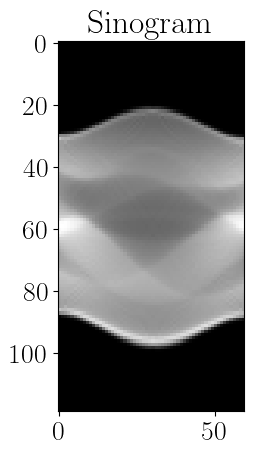

In [7]:
imsize = (n, n)
y = np.reshape(A@phantom.flatten(), (int(np.ceil(n*np.sqrt(2))), n_angles))
plt.title("Sinogram")
plt.imshow(y, cmap='gray')
#ground truth
x = torch.from_numpy(phantom).flatten().float()


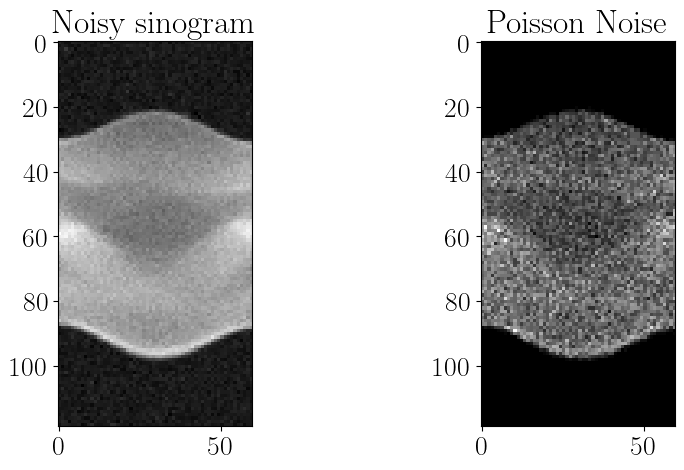

In [33]:
# Add Gaussian and Poisson noise to the sinogram
sigma = 0.75 #Typical noise levels range from 0.01-0.1 (5% of the maximum intensity of the ground truth image)
gauss_y = add_noise(y, noise_type='gaussian', sigma = sigma).float()
poisson_y = add_noise(y, noise_type='poisson').float()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Noisy sinogram")
plt.imshow(gauss_y.numpy(), cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Poisson Noise")
plt.imshow(poisson_y.numpy(), cmap='gray')

Text(0.5, 1.0, 'Noise-free FBP reconstruction')

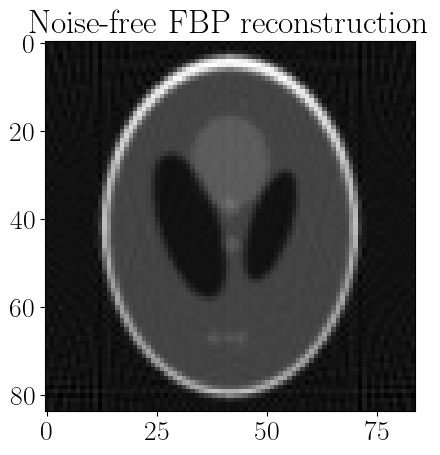

In [8]:
#Noise free FBP
reconstruction_fbp = fbp(y, n_angles)
plt.imshow(reconstruction_fbp, cmap='gray')
plt.title('Noise-free FBP reconstruction')


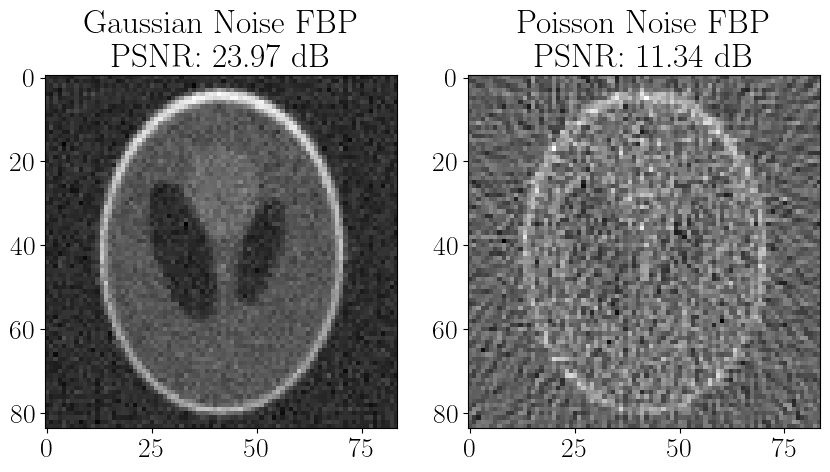

In [9]:
#Noisy reconstruction
s = 0.05
gfbp = fbp(gauss_y, n_angles)
pfbp = fbp(poisson_y, n_angles)
gfbp =  gfbp.reshape(n, n) + torch.randn(n,n)*s
g_psnr = PSNR(x, gfbp)
p_psnr = PSNR(x, pfbp)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title(f"Gaussian Noise FBP \n PSNR: {g_psnr:.2f} dB")
plt.imshow(gfbp, cmap='gray')

plt.subplot(1, 2, 2)
plt.title(f"Poisson Noise FBP \n PSNR: {p_psnr:.2f} dB")
plt.imshow(pfbp, cmap='gray')

# Deep denoisers (DnCNN, DRUNet) - imported from algorithms.py

In [10]:
#Deep denoisers
channels = 1
# DnCNN Zhang 2017 denoiser
dncnn = DnCNN(
    in_channels=channels,
    out_channels=channels,
    pretrained="download",  
    device="cpu",
)

# Zhang 2021 denoiser
drunet = DRUNet(
    in_channels= channels,
    out_channels= channels,
    pretrained="download",
    device="cpu",
)



# Five denoiser choices for the proximal operator - can be imported from algorithms.py

In [ ]:
# equivalent function in algorithms.py
def soft_thresh(x, l):
    return torch.sign(x) * F.relu(torch.abs(x) - l)

def apply_denoiser(x, l, sigma = sigma,  method = 'tv'):
        """
        Denoiser options to replace the proximal step
        """
        if method == 'tv':
            return denoise_tv_chambolle_torch(x, weight = l)
        elif method == 'bm3d':
            #x = torch.to_numpy(x)
            #print(x.shape)
            x = bm3d(x.reshape(imsize), sigma_psd = sigma*5).flatten()
            return torch.from_numpy(x).float()
        elif method == 'proximal':
            return soft_thresh(x, l)
        elif method == 'DnCNN':
            #print('DnCNN')
            x = x.unsqueeze(0).unsqueeze(0)
            x = dncnn(x)
            return x.squeeze(0).squeeze(0)
        elif method == 'DRUNet':
            x = x.reshape(imsize)
            x = x.unsqueeze(0).unsqueeze(0)
            x = drunet(x, sigma = sigma)
            return x.squeeze(0).squeeze(0).flatten().detach()



# PnP-PGD with Lipschitz constant upper bound estimated (power method)

Largest eigenvalue estimate: 4866.83056640625


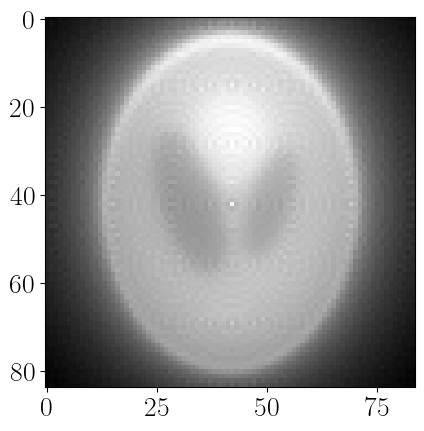

In [13]:
#Upper bound for Lispchitz constant (L) and in turn the upper bound for the stepsize (1/L) - where the upper bound is the largest eigenvalue of the Hessian of f(x), i.e A^T A
H = A.T @ A
ev = power_method(H)
print(f"Largest eigenvalue estimate: {ev}")

#gauss_y.shape
guess = A.T @ (gauss_y.flatten())
plt.imshow(guess.reshape(imsize), cmap= 'gray')

In [ ]:
#BM3D denoiser
x_bm3d, bm3dr, bm3diff, bm3dpairs, bm3dincr = pnp_pgd(A, gauss_y, x, method = 'bm3d', iters = 50, sigma = 1e-4)
#xf_bm3d, fbm3dr, fbm3diff, fbm3dpairs, fbm3dincr = pnp_fista(A, gauss_y, x, method = 'bm3d', iters = 200)

# PnP-PGD - TV, DnCNN and DRUNet

In [35]:
iters = 200
x_prox, proxr, proxdiff, proxpairs, proxincr = pnp_pgd(A, gauss_y, x, method = 'proximal', reg_l = 5e-4, iters = iters, sigma = sigma)
x_tv, tvr, tvdiff, tvpairs, tvincr = pnp_pgd(A, gauss_y, x, method = 'tv', reg_l = 1e-3, iters = iters, sigma = sigma)

proximal-PnP PGD iterations: 100%|██████████| 200/200 [00:05<00:00, 33.63it/s]


PnP-proximal Final PSNR: 24.32 dB


tv-PnP PGD iterations: 100%|██████████| 200/200 [00:05<00:00, 39.17it/s]

PnP-tv Final PSNR: 23.60 dB


In [17]:
x_dncnn, cnnr, cnndiff, cnnpairs, cnnincr = pnp_pgd(A, gauss_y, x, method = 'DnCNN', iters = iters, L = 4000)
a, b, c, d, e = pnp_pgd(A, gauss_y, x, method = 'tv', reg_l = 1e-4, iters = 171, sigma = sigma)
x_dncnn = a

DnCNN-PnP PGD iterations: 100%|██████████| 300/300 [00:28<00:00, 10.58it/s]


PnP-DnCNN Final PSNR: 31.41 dB


tv-PnP PGD iterations: 100%|██████████| 171/171 [00:04<00:00, 42.42it/s]

PnP-tv Final PSNR: 31.00 dB


In [26]:
x_drunet, drur, drudiff, drupairs, druincr = pnp_pgd(A, gauss_y, x, method = 'DRUNet', iters = iters, L = 2500)
x_gs, gsr, gsdiff, gspairs, gsincr = pnp_pgd(A, gauss_y, x, method = 'GS-DRUNet', iters = iters, L = 2500)

DRUNet-PnP PGD iterations: 100%|██████████| 300/300 [03:57<00:00,  1.27it/s]


PnP-DRUNet Final PSNR: 28.51 dB


GS-DRUNet-PnP PGD iterations: 100%|██████████| 300/300 [05:45<00:00,  1.15s/it]

PnP-GS-DRUNet Final PSNR: 27.29 dB


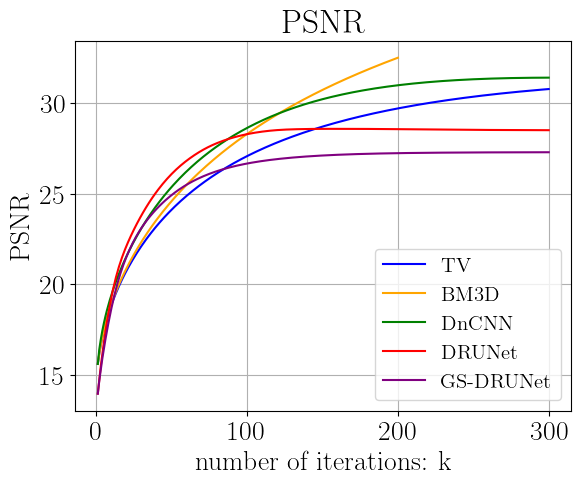

In [ ]:
#Comparison of PSNRs
comparison_plot(tvr,'TV', color='b')
comparison_plot(bm3dr, 'BM3D', color='orange')
comparison_plot(cnnr,'DnCNN', color='green')
comparison_plot(drur,'DRUNet', color='red')



<>:17: SyntaxWarning: invalid escape sequence '\|'
<>:37: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\|'
<>:37: SyntaxWarning: invalid escape sequence '\s'
C:\Users\as5057\AppData\Local\Temp\ipykernel_11028\4032053324.py:17: SyntaxWarning: invalid escape sequence '\|'
  ax2.set_ylabel('$\\|x^{(k+1)} - x^{(k)}\|_2$')
C:\Users\as5057\AppData\Local\Temp\ipykernel_11028\4032053324.py:37: SyntaxWarning: invalid escape sequence '\s'
  ax2.semilogy(iterations, 5/(iterations**0.5), label = '$\\mathcal{O}(1/\sqrt{k})$', linestyle = '--', color = '#FF5AB7', linewidth = 2)
C:\Users\as5057\AppData\Local\Temp\ipykernel_11028\4032053324.py:37: RuntimeWarning: divide by zero encountered in divide
  ax2.semilogy(iterations, 5/(iterations**0.5), label = '$\\mathcal{O}(1/\sqrt{k})$', linestyle = '--', color = '#FF5AB7', linewidth = 2)


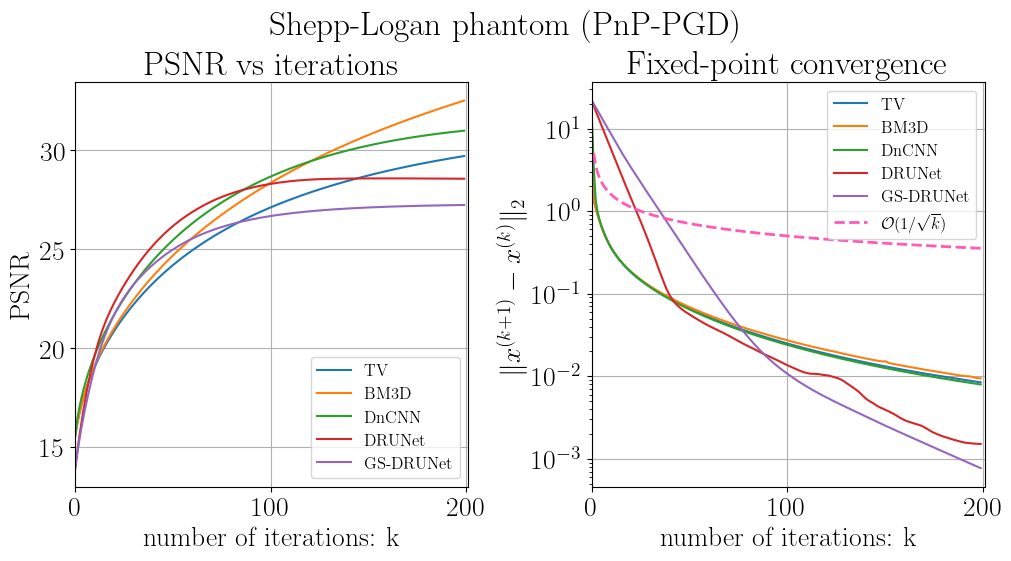

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5.5), constrained_layout = True)
fig.suptitle('Shepp-Logan phantom (PnP-PGD)')
ax1.set_title('PSNR vs iterations')
ax2.set_title('Fixed-point convergence')
def plot_psnrs_differences(psnrs, diffs, method, color='blue'):
    """
    Peak-signal-to-noise ratio (PSNR) and residual plots vs iterations for a prior denoiser
    """

    #fig.suptitle(method)
    ax1.plot(range(0, len(psnrs)), psnrs, label = method)
    ax1.set_ylabel('PSNR')
    ax1.set_xlabel('number of iterations: k')
    ax1.grid(True)

    ax2.semilogy(range(0, len(diffs)),diffs, label = method)
    ax2.set_ylabel('$\\|x^{(k+1)} - x^{(k)}\|_2$')
    ax2.set_xlabel('number of iterations: k')
    ax2.grid(True)
    ax1.set_xlim([0, len(psnrs) + 1])
    ax2.set_xlim([0, len(psnrs) + 1])
    
    return psnrs[-1]

tvpsnr = plot_psnrs_differences(tvr[:200], tvincr[:200], 'TV')
bm3dpsnr = plot_psnrs_differences(bm3dr, bm3dincr, 'BM3D')
dncnnpsnr = plot_psnrs_differences(cnnr[:200], cnnincr[:200], 'DnCNN')
drunetpsnr = plot_psnrs_differences(drur[:200], druincr[:200], 'DRUNet')

psnrs_list = [PSNR(x, gfbp), tvpsnr, bm3dpsnr, dncnnpsnr, drunetpsnr]

iterations = np.arange(200)

#Reference for O(1/sqrt(k)) fixed-pooint convergence for GS-DRUNet denoiser
#ax2.semilogy(iterations, 15/iterations, label = '$\\mathcal{O}(1/k)$', linestyle = '--', color = '#13A49F', linewidth = 2)
ax2.semilogy(iterations, 5/(iterations**0.5), label = '$\\mathcal{O}(1/\sqrt{k})$', linestyle = '--', color = '#FF5AB7', linewidth = 2)

ax1.legend(fontsize = 12)
ax2.legend(fontsize = 12)
plt.savefig('plots/PnPPGDPhantomgraphs.png', dpi = 300)

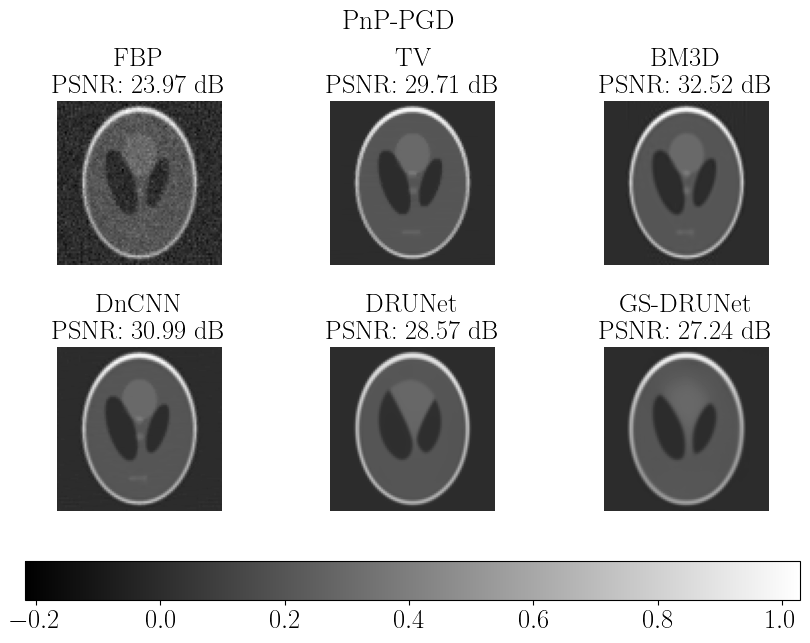

In [29]:
#plotting_estimates1(gfbp.reshape(imsize), xf_tv.reshape(imsize), xf_bm3d.reshape(imsize), xf_dncnn.reshape(imsize), xf_drunet.reshape(imsize), 1, psnrs_list, title='PnP-FISTA')
plotting_estimates1(gfbp.reshape(imsize), x_tv.reshape(imsize), x_bm3d.reshape(imsize), x_dncnn.reshape(imsize), x_drunet.reshape(imsize), x_gs.reshape(imsize), psnrs_list, title='PnP-PGD')
#plt.tight_layout()